# Rare Cell Coverage (cell type)

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import pickle

# Get the file path from environment variable
file_path_env = '/fast/AG_Ohler/ekarimi/projects/FACS_Sampling/data'
OBS_FEATURES = ['prediction','organ','sample_group','label','group','celltype','sample_id']
DROP_FEATURES = ['SSC-B-H','SSC-B-A']

REFERENCES = [1, 5, 10, 20, 34]
references = [1, 5, 10, 20]
METHODS = ['random', 'cubic', 'hopper', 'atomic']
methods = ['random', 'cubic', 'hopper']
SIZES = [50000, 100000, 200000]
REPS = [i for i in range(5)]
label_key = 'celltype'


directory = "lcmv/benchmark"
PATH = os.path.join(file_path_env, directory)

In [2]:
ref = 1
method = 'cubic'
size = 50000
rep = 0
# REFERENCES = [1, 5]
methods = ['random', 'cubic', 'atomic', 'hopper']


In [37]:
reference_adatas = {}
for ref in REFERENCES:
    address = os.path.join(PATH, f"{ref}/adata.h5ad")
    adata = sc.read_h5ad(address)
    adata.obs[label_key] = adata.obs[label_key].astype('category')
    adata.var.index = adata.var.index.astype('object')
    reference_adatas[ref] = adata

KeyboardInterrupt: 

In [ ]:
res = {}
new_label_orders = {}

for ref in REFERENCES:
    adata = reference_adatas[ref]

    real_counts = adata.obs[label_key].value_counts()
    rare_dict = real_counts < adata.shape[0]/100
    rare_types = [x for x in rare_dict.keys() if rare_dict[x]==True]
    adata.obs['rare'] = adata.obs.apply(lambda x: True if x[label_key] in rare_types else False , axis=1)
    adata.obs['real_count'] = adata.obs.apply(lambda x: real_counts[x[label_key]] , axis=1)

    label_order = adata.obs[label_key].value_counts().keys().values
    
    group_dict = {
        label_key:[],
        'count':[],
        'method':[],
        'ref_size':[],
        'sample_size':[],
        'rep':[],
        # 'rare':[],
        'real_count':[],
                 }

    for size in SIZES:
        for method in METHODS:
            for rep in REPS:
                if method == 'atomic':
                    if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")):
                        atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")
                        indices = pd.read_csv(atomic_address)['x'].values.astype(str)
                    else:
                        continue
                else:
                    samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                    with open(samples_address, 'rb') as handle:
                         samples= pickle.load(handle)
                    indices = samples[0]

                counts = adata[indices].obs[label_key].value_counts().tolist()
                labels = adata[indices].obs[label_key].value_counts().keys().tolist()
                method_rep = [method for _ in counts]
                size_rep = [size for _ in counts]
                ref_rep = [ref for _ in counts]
                rep_rep = [rep for _ in counts]
                real_count = real_counts[labels].values
                # rare = rare_dict[labels].values

                group_dict[label_key].extend(labels)
                group_dict['count'].extend(counts)
                group_dict['method'].extend(method_rep)
                group_dict['ref_size'].extend(ref_rep)
                group_dict['sample_size'].extend(size_rep)
                group_dict['rep'].extend(rep_rep)
                # group_dict['rare'].extend(rare)
                group_dict['real_count'].extend(real_count)
                
                
                

    gdf = pd.DataFrame.from_dict(group_dict)
    # cc = adata.obs[label_key].value_counts()
    # gdf['coverage_percent'] = gdf.apply(lambda x: (x['count'] / cc[x[label_key]]) * 100, axis=1)
    
    res[ref] = gdf[gdf[label_key].isin(rare_types)]
    
    new_label_order = []
    for i in range(len(label_order)):
        if label_order[i] in rare_types:
            new_label_order.append(label_order[i])
    new_label_orders[ref] = new_label_order

In [34]:
res[1][res[1]['method'] == 'random']

,celltype,count,method,ref_size,sample_size,rep,real_count
11,CD4_LCMV_spec,452,random,1,50000,0,9443
12,Plasma_cells,377,random,1,50000,0,7102
13,pDC_like,322,random,1,50000,0,6129
14,pDCs,291,random,1,50000,0,5597
15,CD138_pos_PC_like,274,random,1,50000,0,4929
...,...,...,...,...,...,...,...
940,TCRgd_T,874,random,1,200000,4,4216
941,cDC2,734,random,1,200000,4,3801
942,Eosino,592,random,1,200000,4,2577
943,interacting,150,random,1,200000,4,687


In [23]:
output_mean = {}
output_std = {}  # Dictionary to store standard deviations

for ref in REFERENCES:
    df = res[ref]
    output_mean[ref] = None
    output_std[ref] = None  # To store std dev
    b_mean = []
    b_std = []
    for size in SIZES:
        a_mean = []
        a_std = []
        for method in METHODS:
            sample_counts = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count']
            # print(sample_counts.shape)
            mean_count = sample_counts.mean()  # Mean over replicates
            std_count = sample_counts.std()  # Std deviation over replicates
            
            a_mean.append(mean_count)
            a_std.append(std_count)  # Append standard deviation
            
        b_mean.append(a_mean)
        b_std.append(a_std)  # Append std for all methods for this sample size
    
    # Transpose and store in the output dictionaries
    output_mean[ref] = np.array(b_mean).T
    output_std[ref] = np.array(b_std).T


In [20]:
output_std

{1: array([[ 132.91015993,  269.87358265,  522.380515  ],
        [ 753.22710915, 1384.14165976, 2311.90755244],
        [ 444.75213735,  812.11087234, 1464.03043684],
        [ 444.45231787,  845.30057352, 1436.09578172]]),
 5: array([[ 135.40791886,  265.75737285,  538.24176951],
        [ 958.74340569, 1829.99447183, 3236.16986443],
        [ 538.33239902,  948.9025044 , 1779.1787788 ],
        [ 437.25513264,  834.7241463 , 1868.76075111]]),
 10: array([[ 134.1561746 ,  271.90722908,  546.54146135],
        [ 973.65132174, 1887.19149121, 3415.88591575],
        [ 655.48607949, 1121.49994768, 1896.41351471],
        [ 476.16826943,  953.70480608, 1849.25730939]]),
 20: array([[ 131.83698809,  271.84658714,  536.21944525],
        [1097.20429813, 2171.18913154, 3936.16559321],
        [ 754.38263879, 1283.70072423, 2191.25109693],
        [ 476.32658536,  923.37509216, 1796.44482799]]),
 34: array([[ 134.88835746,  271.73105251,  544.75897535],
        [1173.54001975, 2345.58436007, 

In [17]:
y_stds.shape

(4, 3)

In [18]:
y_means.shape

(4, 3)

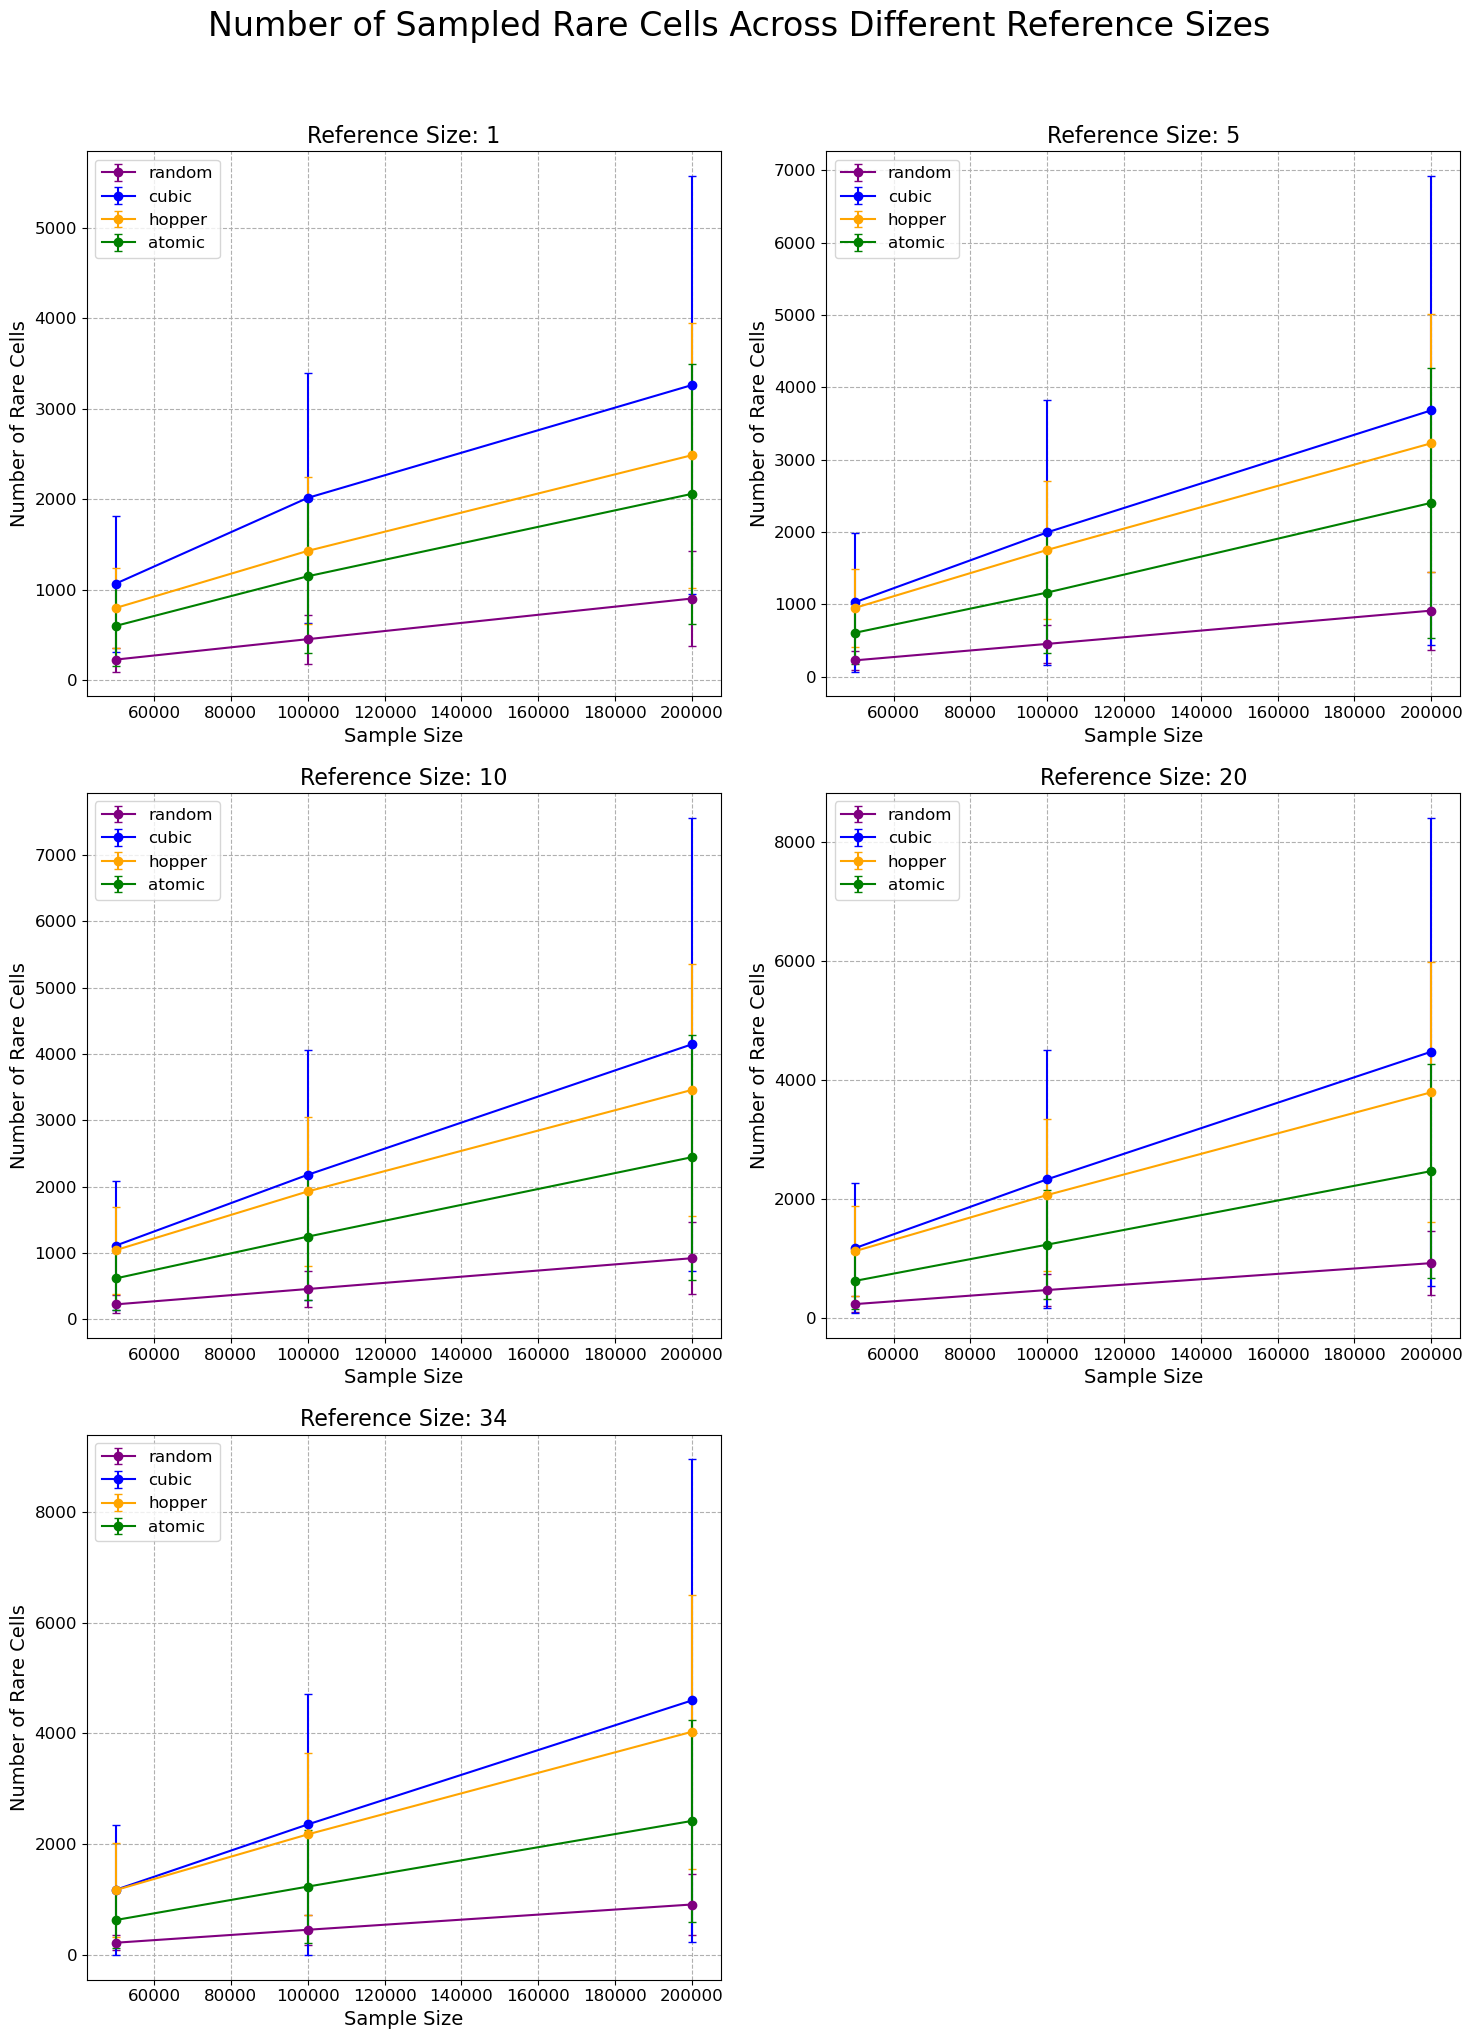

In [19]:
x_values = np.array(SIZES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, ref in enumerate(output_mean.keys()):
    y_means = output_mean[ref]
    y_stds = output_std[ref]  # Retrieve the standard deviations
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot with error bars
    for j, (y_mean, y_std) in enumerate(zip(y_means, y_stds)):
        ax.errorbar(x_values, y_mean, yerr=y_std, fmt='-o', color=colors[j % len(colors)], label=METHODS[j], capsize=3)

    # Customizations for the subplot
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Reference Size: {ref}')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output_mean), n_rows * n_cols):
    fig.delaxes(axes[i])
    
fig.suptitle('Number of Sampled Rare Cells Across Different Reference Sizes', size=24, y=1.02)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_ref_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [ ]:
output = {}
for ref in REFERENCES:
    df = res[ref]
    output[ref] = None
    b= []
    for size in SIZES:
        a = []
        for method in METHODS:
            sample_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count'].sum()
            sample_count /= len(REPS)
            # real_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['real_count'].sum()
            # real_count /= len(REPS)
            # a.append(sample_count/real_count)
            a.append(sample_count)
        b.append(a)
    b = np.array(b).T
    output[ref] = b

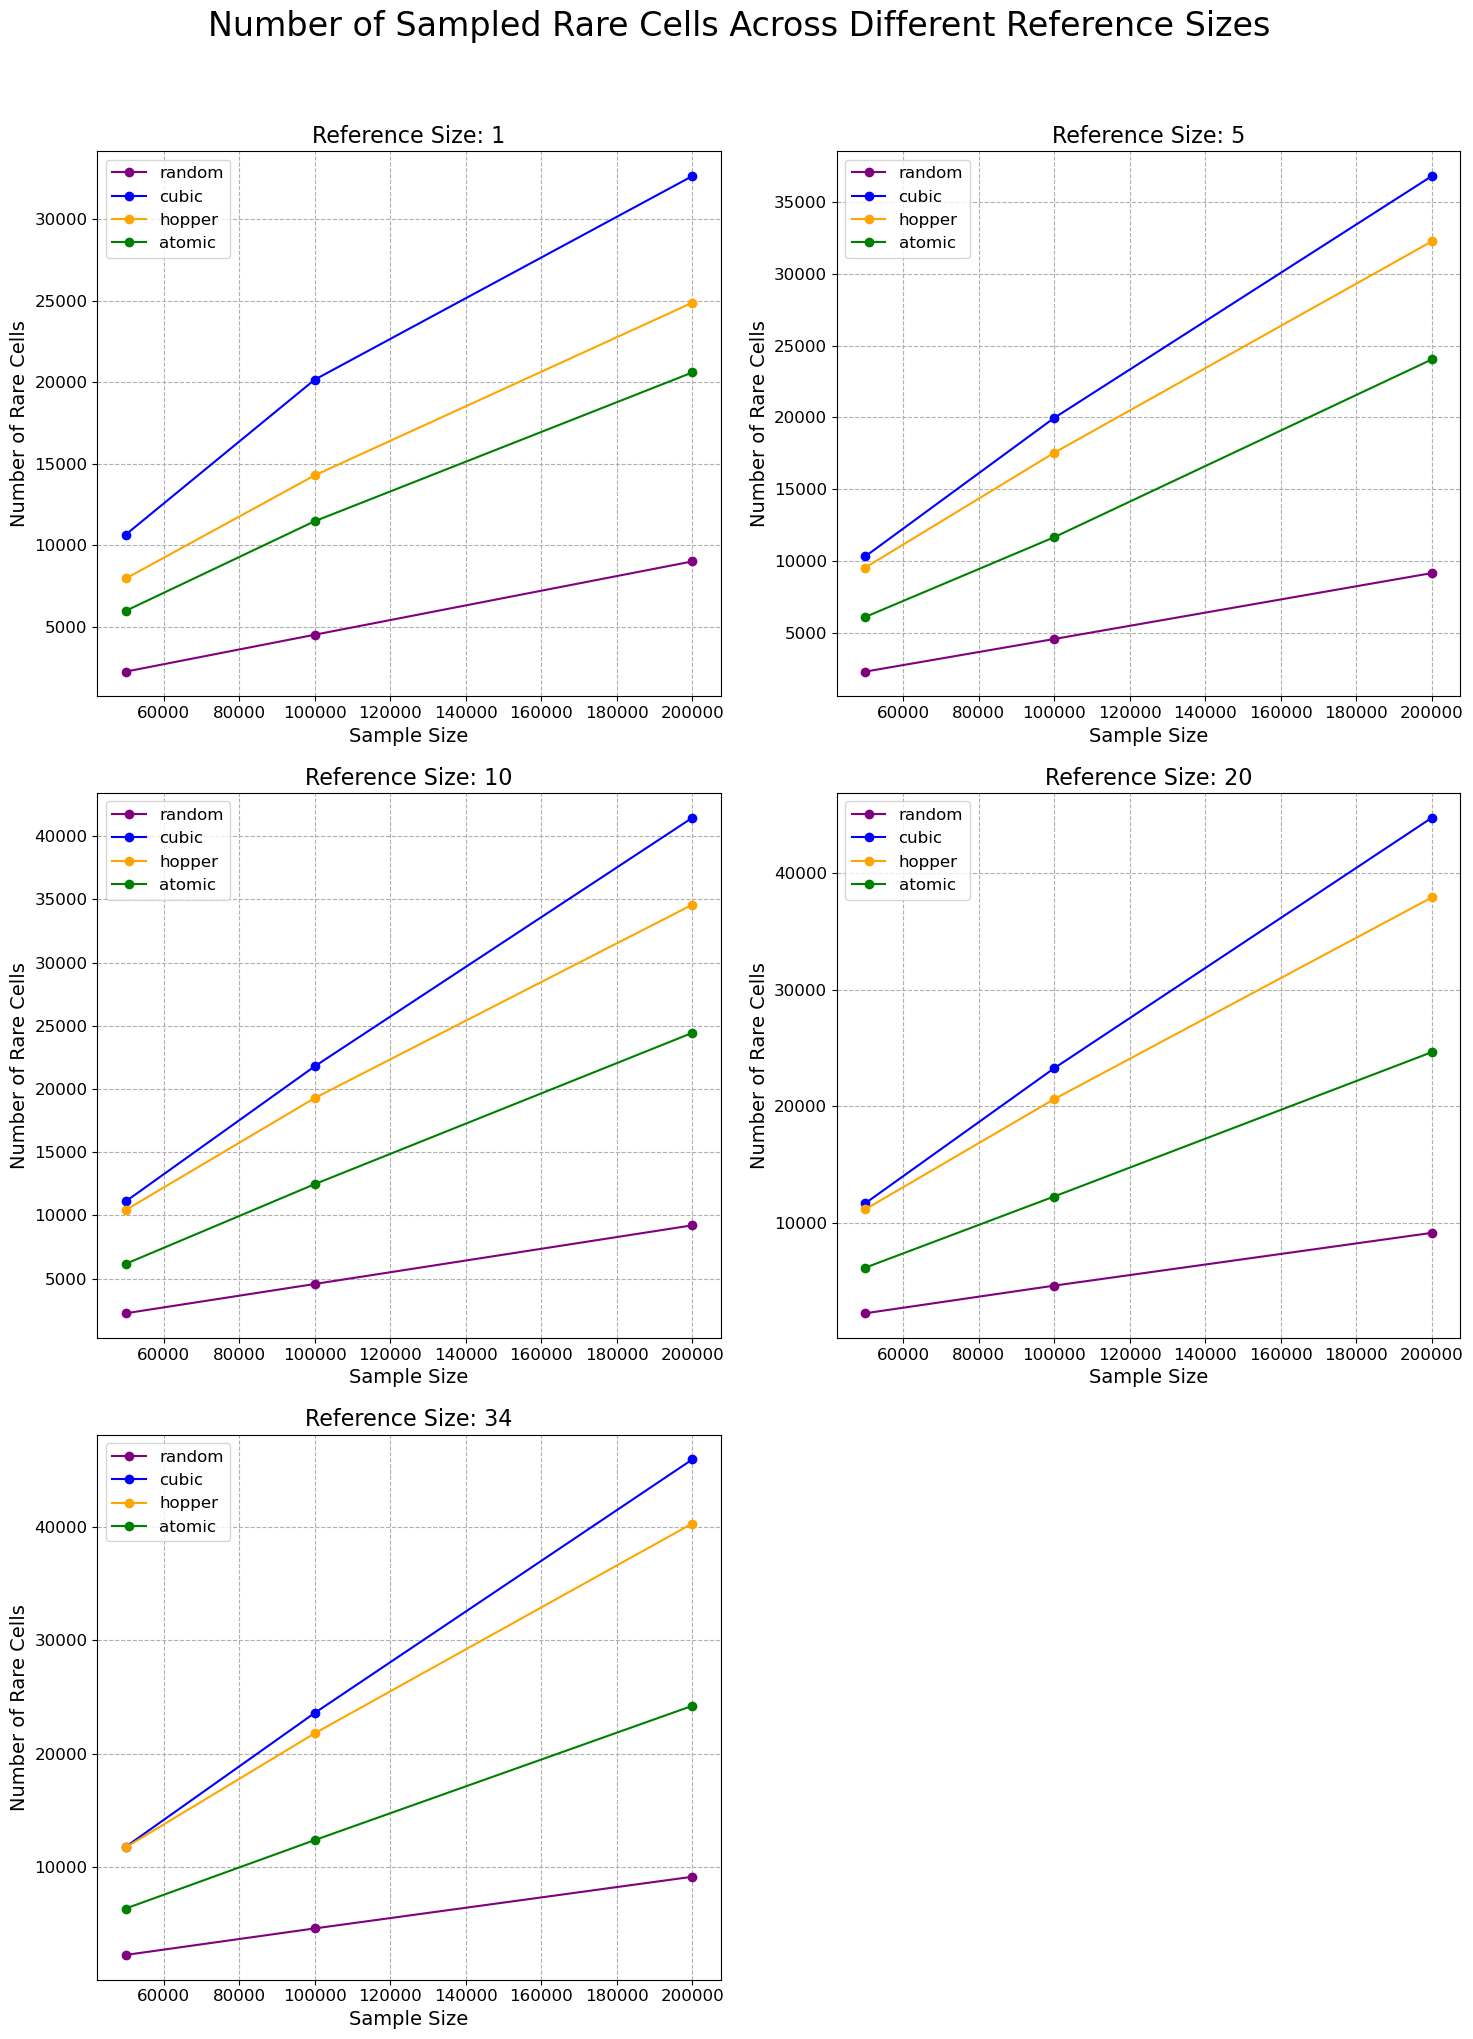

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(SIZES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

y_min = 0  # Replace with your desired minimum y value
y_max = 0.9  # Replace with your desired maximum y value

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, ref in enumerate(output.keys()):
    y_streams = output[ref]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Reference Size: {ref}')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output), n_rows * n_cols):
    fig.delaxes(axes[i])
    
    
fig.suptitle('Number of Sampled Rare Cells Across Different Reference Sizes', size=24, y=1.02)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_ref_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [10]:
output2 = {}
for size in SIZES:    
    output2[size] = None
    b= []
    for ref in REFERENCES:
        df = res[ref]
        a = []
        for method in METHODS:
            sample_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count'].sum()
            sample_count /= len(REPS)
            # real_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['real_count'].sum()
            # real_count /= len(REPS)
            # a.append(sample_count/real_count)
            a.append(sample_count)
        b.append(a)
    b = np.array(b).T
    output2[size] = b

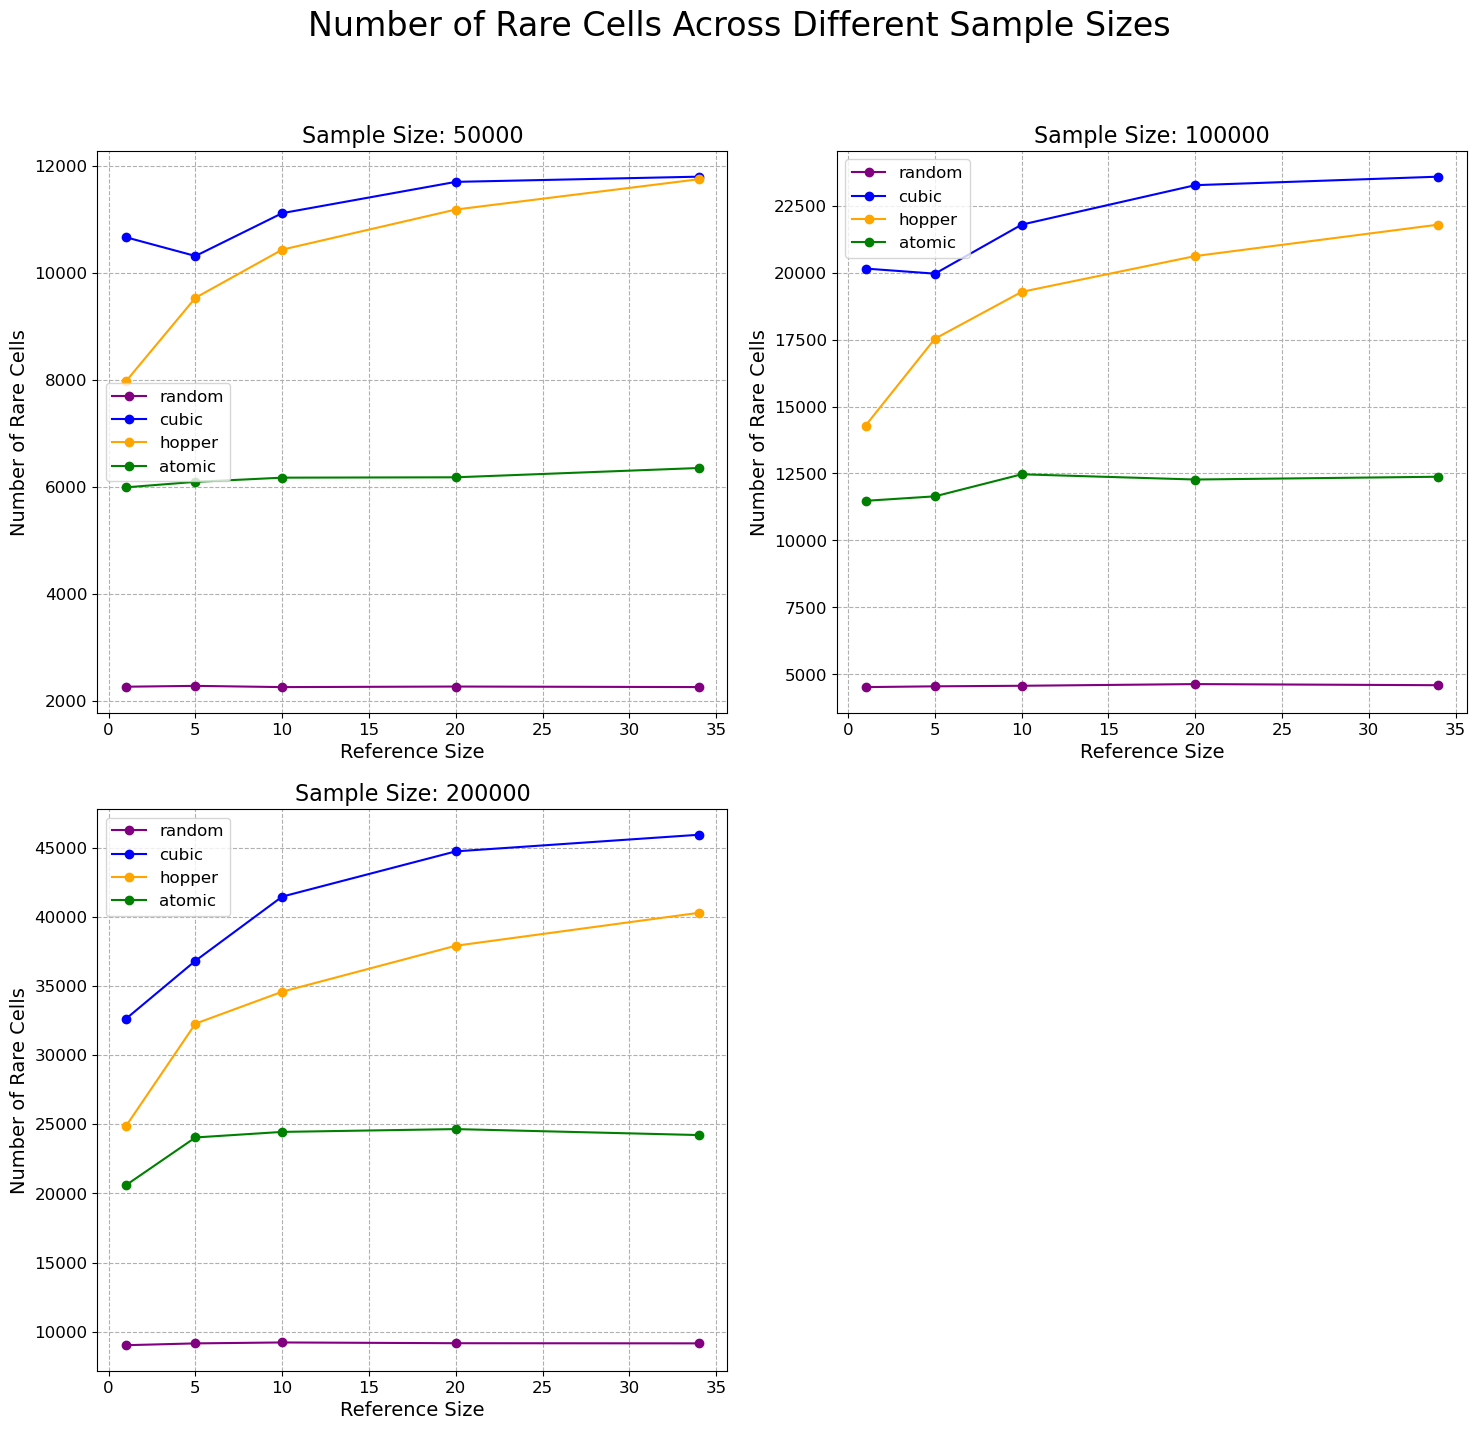

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(REFERENCES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

y_min = 0  # Replace with your desired minimum y value
y_max = 0.9  # Replace with your desired maximum y value

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, size in enumerate(output2.keys()):
    y_streams = output2[size]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Reference Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Sample Size: {size}')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output2), n_rows * n_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping
fig.suptitle('Number of Rare Cells Across Different Sample Sizes', size=24, y=1.02)

fig.tight_layout()

# plt.subplots_adjust(top=0.9)

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_sample_size_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()
